In [26]:
%matplotlib notebook
from QDP import qdp, atom
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize

In [45]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_names = [
    '2017_12_11_16_00_52_temperature-test',
    '2017_12_11_16_13_13_temperature-test-no-op'
]
exp_date = '_'.join(exp_names[0].split('_')[:3])

cuts = [[10],[2]]

q = qdp.QDP(base_data_path=dp)
for exp_name in exp_names:
    experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
    q.load_data_file(experiment_file)
q.set_thresholds(cuts)

name 'fort_exp' is not defined
name 'fort_exp' is not defined


In [46]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

In [47]:
retention = q.apply_thresholds()

In [48]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.00	retention:0.990 +- 0.008
ivar:	4.00	retention:1.000 +- 0.006
ivar:	8.00	retention:0.911 +- 0.024
ivar:	12.00	retention:0.891 +- 0.026
ivar:	16.00	retention:0.782 +- 0.035
ivar:	20.00	retention:0.604 +- 0.041
ivar:	24.00	retention:0.475 +- 0.042
ivar:	28.00	retention:0.505 +- 0.042
ivar:	32.00	retention:0.416 +- 0.041
ivar:	36.00	retention:0.495 +- 0.042
ivar:	40.00	retention:0.300 +- 0.039
ivar:	0.00	retention:0.941 +- 0.020
ivar:	4.00	retention:1.000 +- 0.006
ivar:	8.00	retention:0.960 +- 0.016
ivar:	12.00	retention:0.900 +- 0.025
ivar:	16.00	retention:0.851 +- 0.030
ivar:	20.00	retention:0.723 +- 0.037
ivar:	24.00	retention:0.720 +- 0.038
ivar:	28.00	retention:0.594 +- 0.041
ivar:	32.00	retention:0.600 +- 0.041
ivar:	36.00	retention:0.500 +- 0.042
ivar:	40.00	retention:0.360 +- 0.040


In [49]:
q.save_experiment_data(filename_prefix='cooling_attempt_data')

In [50]:
def fnode_release_recapture(t, T_uk):
    U_mk = 1.4  # 1.4 nominal
    wr_um = 2.5
    zr_um = 17.9  # calculated
    fr_khz = 48.0*np.sqrt(U_mk/1.4)
    fa_khz = 4.7*np.sqrt(U_mk/1.4)
    n=500000
    try:
        res = np.zeros(len(t))
        for i in xrange(len(t)):
            res[i] = atom.release_recapture(t[i], T_uk, U_mk, wr_um, zr_um, fr_khz, fa_khz, n=n)
        return res
    except Exception as e:
        print(e)
        return atom.release_recapture(t, T_uk, U_mk, wr_um, zr_um, fr_khz, fa_khz, n=n)

def residuals(T_uk, y, t, p0, sigma):
    res = (y - fnode_release_recapture(t, T_uk)*p0)/np.power(sigma,2)
    print "T_uk = {}, -> {}".format(T_uk, np.sum(np.power(res, 2)))
    return res

def ls_err(T_uk, y, t, f0):
    res = residuals(T_uk, y, t, f0)
    return np.sum(np.power(res, 2))

<IPython.core.display.Javascript object>


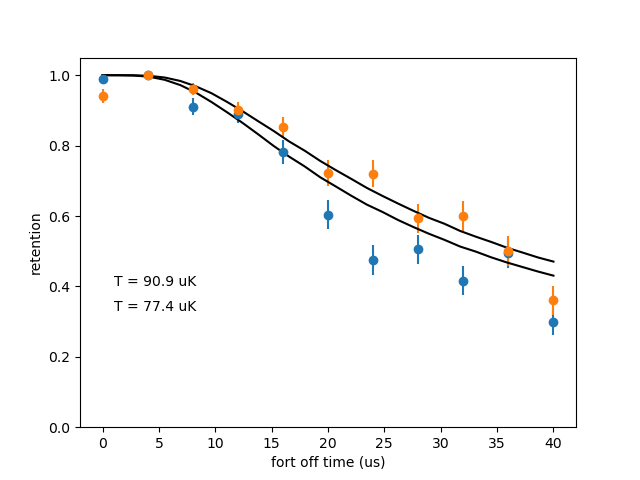

T_uk = [ 89.], -> 62897.5202791
T_uk = [ 93.45], -> 63102.6146564
T_uk = [ 90.93749705], -> 62260.7437555
T_uk = [ 95.4843719], -> 66667.6285964
T_uk = [ 88.13773455], -> 62427.2374209
T_uk = [ 90.23755642], -> 62815.9322557
T_uk = [ 40.], -> 159229.966424
T_uk = [ 42.], -> 146168.163587
T_uk = [ 75.25349735], -> 35358.7750021
T_uk = [ 79.01617222], -> 34866.091326
T_uk = [ 77.95408784], -> 34796.2172636
T_uk = [ 81.85179224], -> 36521.4928022
T_uk = [ 77.37588696], -> 34734.5910103
T_uk = [ 81.24468131], -> 36215.0165235


In [51]:
fig, ax = plt.subplots()
guesses = [89, 40]
T_opts = []
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
    x = optimize.least_squares(
        residuals,
        np.array(guesses[e]),
        args=(retention['retention'][e], retention['ivar'][e], retention['retention'][e][1], retention['error'][e]),
        diff_step=0.05,
        xtol=0.01
    )
    if x['success']:
        T_opt = x['x'][0]
    T_opts.append(T_opt)
    xs = np.linspace(min(retention['ivar'][e]), max(retention['ivar'][e]), 30)
    ax.plot(xs, fnode_release_recapture(xs, T_opt)*retention['retention'][e][1], 'k-')
    ax.text(1, 0.4-e*0.07, "T = {:.1f} uK".format(T_opt))
    
ax.set_ylim(0, 1.05)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'mz_readout_heating_rate.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

<IPython.core.display.Javascript object>


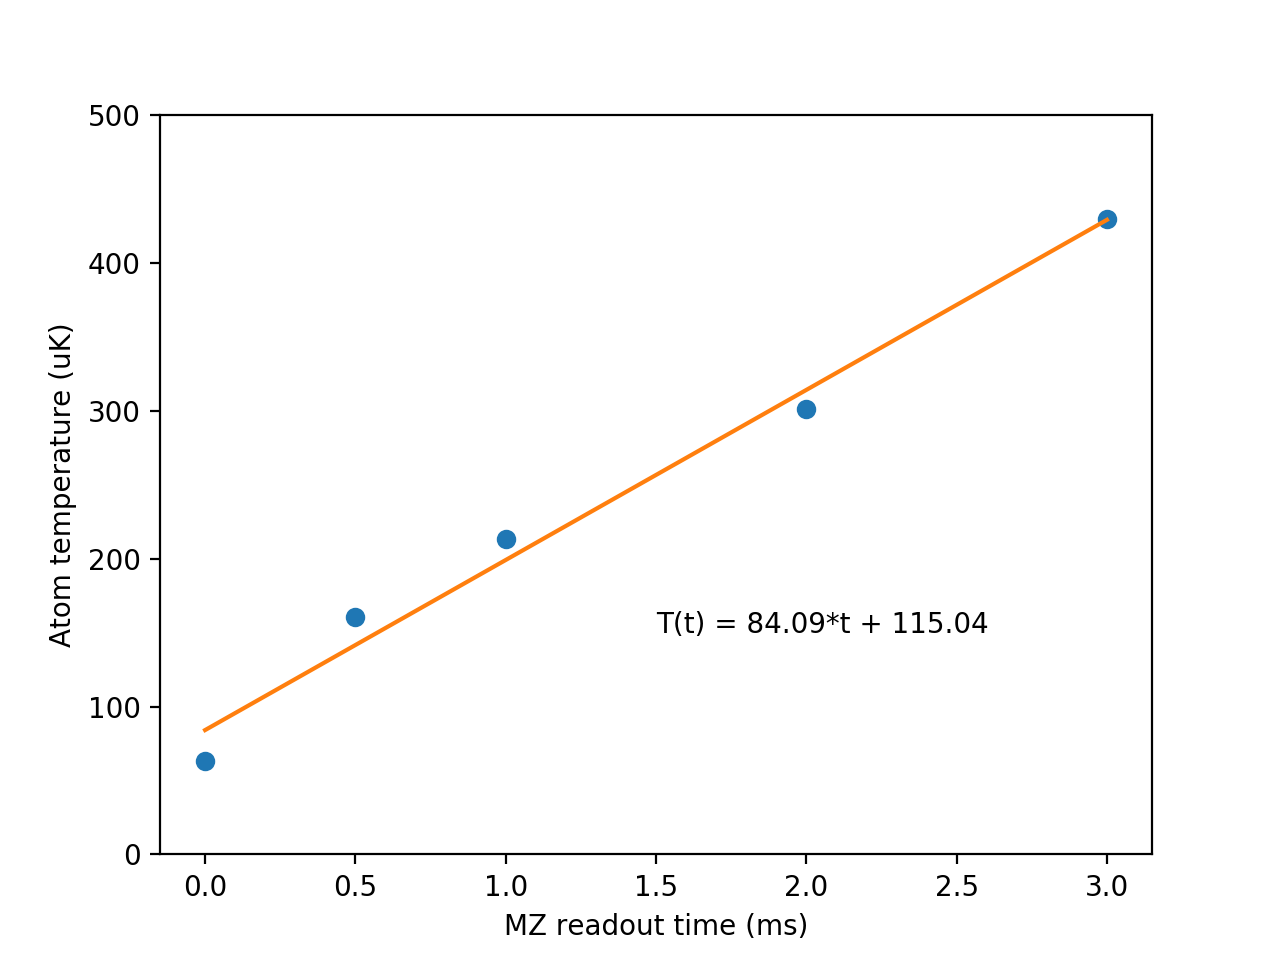

In [24]:
readout_time = [0, 0.5, 1, 2, 3]
fig, ax = plt.subplots()
coeffs = np.polyfit(readout_time, T_opts, 1)
ax.plot(readout_time, T_opts, 'o')
xs = np.linspace(0, 3, 100)
ax.plot(xs, np.poly1d(coeffs)(xs))
ax.set_xlabel('MZ readout time (ms)')
ax.set_ylabel('Atom temperature (uK)')
ax.text(1.5, 150, "T(t) = {:.2f}*t + {:.2f}".format(coeffs[1], coeffs[0]))
ax.set_ylim(0, 500)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'mz_readout_heating_rate_actual.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [ ]:
fig, ax = plt.subplots()

ax.plot(Ts, fnode_release_recapture(, T_opt)*retention['retention'][e][0], 'k-')